# Fruits360 - Multiclass classification of fruits &amp; vegitable images (Kaggle)
* This workbook illustrates my attempt to solve the [Kaggle Fruits360 challenge](https://www.kaggle.com/moltean/fruits).
* I'll be using Keras on Tensorflow (actually Tensorflow's implementation of Keras, available in `tf.keras` package, so you don't have to additionally install the Keras library).
* I will be using the VGG16 pre-trained model, which is a complex CNN trained on the ImageNet image set.
* This workbook also shows you how you can connect to Kaggle from a Colab Notebook and download dataset(s) for use locally - we will be downloading the Fruits360 datset from Kaggle to our Colab environment.

<font color='firebrick'>It is recommended that you run this notebook on a GPU only, like ones available on Google Colab or Kaggle</font>

Following cell sets up access to our Google Drive

In [0]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # We mount our Goofgle Drive to this foloder - following line will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(grive_path, "Colab Notebooks/")
    KERAS_COLAB_NOTEBOOKS_PATH = os.path.join(COLAB_NOTEBOOKS_PATH, 'keras')
    
    if os.path.exists(KERAS_COLAB_NOTEBOOKS_PATH):
        print('You Keras Colab notebooks are available at ', KERAS_COLAB_NOTEBOOKS_PATH)
    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        sys.path.append(KERAS_COLAB_NOTEBOOKS_PATH)
        print('NOTE: {} is appended to sys.path!'.format(KERAS_COLAB_NOTEBOOKS_PATH))
        # and test it
        import kr_helper_funcs as kru
        MODEL_SAVE_DIR = os.path.join(KERAS_COLAB_NOTEBOOKS_PATH, 'model_states')
        IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/kaggle/fruits360"
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    IMAGES_ZIP_DIR = "./images/kaggle/fruits360"
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Your Google Drive is mounted at  /content/drive/My Drive/
You Keras Colab notebooks are available at  /content/drive/My Drive/Colab Notebooks/keras
NOTE: /content/drive/My Drive/Colab Notebooks/keras is appended to sys.path!


In [0]:
# if you want to use Tensorflow 2.0, run the following line
# You may have to restart your runtime after installation & will be prompted to do so
!pip install tensorflow-gpu==2.0

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 51.3MB/s 
     |████████████████████████████████| 450kB 50.6MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existi

## Downloading the dataset from Kaggle
You can download datasets directly from Kaggle into a Colab environment by running the following steps:
* Login to your Kaggle account and _create a new API Token_ from your profile page (click the `Create API Token` button and download the `kaggle.json` file locally i.e. to your disk.
* Upload the `kaggle.json` that you downloaded to Colab  and move the file to `~/.kaggle/kaggle.json`
* Install Python packages `kaggle` and `kaggle-cli` that needed to access Kaggle programatically. These can be installed using `pip`
* Now you can access datasets on Kaggle
    * Run `!kaggle datasets list` shell command to list all available datasets (may no be such a useful command!)
    * Run `!datasets list -s <<dataset_name>>` to search for a dataset (e.g. for the Malaria dataset, I used `kaggle list -s malaria`)
    * Copy dataset locally using `!kaggle datasets download -d <<full_path_of_dataset>> -p <<target_folder_path>>`

Run the following cells to download the [Fruits360 dataset](https://www.kaggle.com/moltean/fruits) from Kaggle to your Colab environment.

In [0]:
# assuming you downloaded kaggle.json file to your desktop, run this cell to upload that file to Colab
# this sometimes causes problems, especially if I am behind a firewalls and uploads are jammed!
# This command will display a "upload file" prompt - select the kaggle.json file from your disk & upload

# Uncomment following 2 lines to upload local kaggle.json file to Colab - the file will be uploaded to
# the folder on your Google drive from where you will this this workbook.
# from google.colab import files
# files.upload()

In [0]:
# so I uploaded my kaggle.json to my Google drive, which I can easily copy into Colab workspace :)
!ls -al "/content/drive/My Drive/Colab Notebooks/kaggle.json"

-rw------- 1 root root 63 Aug 19 12:21 '/content/drive/My Drive/Colab Notebooks/kaggle.json'


In [0]:
# Run this cell to copy the uploaded kaggle.json file to ~/.kaggle/kaggle.json 
# Kaggle expects the token file to be located here!!
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Colab Notebooks/kaggle.json" ~/.kaggle/
# give "me" full access to kaggle.json (i.e. read/write & execute)
!chmod 600 ~/.kaggle/kaggle.json
# confirm that ~/.kaggle folder has kaggle.json file
!ls ~/.kaggle
# display contents of the kaggle.json file (optional)
!cat ~/.kaggle/kaggle.json

kaggle.json
{"username":"mjbhobe","key":"3e759073242031b578fa32410ccd432a"}

In [0]:
# install Python packages require to access Kaggle datasets
!pip install -q kaggle
!pip install -q kaggle-cli

In [0]:
# Vola! You now have access to Kaggle datasets

# to list **all** the datasets available on Kaggle, run the following shell command
#!kaggle datasets list

In [0]:
# We can look for a specific dataset (e.g. the fruits dataset) like this
# Search Command is: kaggle datasets list -s complete_or_part_name_of_dataset

!kaggle datasets list -s fruits  # I don't know the exact name, so I used a part-name - fruits

ref                                                         title                                               size  lastUpdated          downloadCount  
----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
moltean/fruits                                              Fruits 360                                         734MB  2019-11-04 21:16:32          30596  
sriramr/fruits-fresh-and-rotten-for-classification          Fruits fresh and rotten for classification           4GB  2018-08-24 15:05:40           1110  
mjamilmoughal/fruits-with-colors-dataset                    Fruits with colors dataset                          816B  2018-01-13 10:22:33           2469  
mbkinaci/fruit-images-for-object-detection                  Fruit Images for Object Detection                   28MB  2018-07-01 20:21:59           3709  
raghu07/vegetable-and-fruits-price-in-india                 Daily Vege

The first one is the one we are looking for. Let's download the zip file to our `/tmp` folder - **this completes the download of data from Kaggle**

In [0]:
# download command: kaggle datasets download -d <<file_name>> -p <<dest>>

!kaggle datasets download -d moltean/fruits -p /tmp
!ls /tmp

fruits.zip: Skipping, found more recently modified local copy (use --force to force download)
drivefs_ipc.0  drivefs_ipc.0_shell  fruits-360_dataset	fruits.zip  tmpflwvx7sj


Now that we have _downloaded_ data from Kaggle to our local Colab environment, let's unzip the contents.

In [0]:
# and let us unzip cell-images-for-detecting-malaria.zip to /tmp folder
import os, shutil
import zipfile

zip_file_path = '/tmp/fruits.zip'
assert os.path.exists(zip_file_path)

# extract all files to /tmp
print('Source zip: %s' % zip_file_path)
print('Extracting all images...', end='', flush=True)
zip_ref = zipfile.ZipFile(zip_file_path, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()
print('done!', flush=True)

Source zip: /tmp/fruits.zip
Extracting all images...done!


In [0]:
# now unhide the left panel in Colab, click the Files 'tab' & browse to /tmp folder
# you should see the following folders under /tmp
# /tmp
#   + fruits-360_dataset
#       + fruits-360
#           + Training   (training dataset images - several sub-folders under this folder)
#           + Test       (test dataset images - several sub-folders under this folder)
#           + ....       (and many more that I am not interested in)

train_folder_root = '/tmp/fruits-360_dataset/fruits-360/Training'
test_folder_root = '/tmp/fruits-360_dataset/fruits-360/Test'

In [0]:
# a quick dict of category-id to category-name (category name is parent folder under which image is present)
fruit_category_names = sorted(os.listdir(train_folder_root))
fruit_categories = {}
for i, name in enumerate(fruit_category_names):
    fruit_categories[i] = name

NUM_CLASSES = len(fruit_categories.keys())
print('Detected %d classes' % NUM_CLASSES)

Detected 120 classes


## About the Kaggle Dataset

**Content**
The following fruits and are included: 
Apples (different varieties: Crimson Snow, Golden, Golden-Red, Granny Smith, Pink Lady, Red, Red Delicious), Apricot, Avocado, Avocado ripe, Banana (Yellow, Red, Lady Finger), Beetroot Red, Blueberry, Cactus fruit, Cantaloupe (2 varieties), Carambula, Cauliflower, Cherry (different varieties, Rainier), Cherry Wax (Yellow, Red, Black), Chestnut, Clementine, Cocos, Dates, Eggplant, Ginger Root, Granadilla, Grape (Blue, Pink, White (different varieties)), Grapefruit (Pink, White), Guava, Hazelnut, Huckleberry, Kiwi, Kaki, Kohlrabi, Kumsquats, Lemon (normal, Meyer), Lime, Lychee, Mandarine, Mango (Green, Red), Mangostan, Maracuja, Melon Piel de Sapo, Mulberry, Nectarine (Regular, Flat), Nut (Forest, Pecan), Onion (Red, White), Orange, Papaya, Passion fruit, Peach (different varieties), Pepino, Pear (different varieties, Abate, Forelle, Kaiser, Monster, Red, Williams), Pepper (Red, Green, Yellow), Physalis (normal, with Husk), Pineapple (normal, Mini), Pitahaya Red, Plum (different varieties), Pomegranate, Pomelo Sweetie, Potato (Red, Sweet, White), Quince, Rambutan, Raspberry, Redcurrant, Salak, Strawberry (normal, Wedge), Tamarillo, Tangelo, Tomato (different varieties, Maroon, Cherry Red, Yellow), Walnut.

**Dataset properties**
* Total number of images: 82213.

**Training set size:**
* 61488 images (one fruit or vegetable per image).

**Test set size:**
* 20622 images (one fruit or vegetable per image).

**Number of classes:**
* 120 (fruits and vegetables).

**Image size:**
* 100x100 pixels.

In [0]:
import warnings
warnings.filterwarnings('ignore')  # ignore all warnings

import sys, os, random
import numpy as np
import tensorflow as tf
print('Using Tensorflow version ', tf.__version__)
import cv2
print('Using OpenCV version ', cv2.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image
%matplotlib inline

USING_TF2 = (tf.__version__.startswith('2'))

import kr_helper_funcs as kru

plt.style.use('seaborn')
sns.set_style('darkgrid')

float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(threshold=np.inf, suppress=True, precision=4, linewidth=110)

seed = 123
random.seed(seed)
np.random.seed(seed)
if USING_TF2:
    tf.random.set_seed(seed)
else:
    tf.set_random_seed(seed)

Using Tensorflow version  2.0.0
Using OpenCV version  3.4.3


In [0]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS = 100, 100, 3
LR_START, LR_WEIGHT_DECAY = 1e-1, 1e-4
NUM_EPOCHS, BATCH_SIZE = 30, 128

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255)
# I am splitting test dataset into cross-val & test datasets in 70:30 ratio 
# (since both should ideally be drawn from same population)
test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.3)

# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_folder_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical')

eval_generator = test_datagen.flow_from_directory(
    train_folder_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    subset='training')

test_generator = test_datagen.flow_from_directory(
    test_folder_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical',
    subset='validation')

# calculate training/cross-val and testing steps
train_steps = train_generator.n // BATCH_SIZE
eval_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE

print('Training set size %d, step-size %d' % (train_generator.n, train_steps))
print('Cross-val set size %d, step-size %d' % (eval_generator.n, eval_steps))
print('Test set size %d, step-size %d' % (test_generator.n, test_steps))

Found 60498 images belonging to 120 classes.
Found 42388 images belonging to 120 classes.
Found 6127 images belonging to 120 classes.
Training set size 60498, step-size 472
Cross-val set size 42388, step-size 331
Test set size 6127, step-size 47


In [0]:
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=8, num_cols=8,
                   plot_title=None, fig_size=None):
    """ display a random selection of images & corresponding labels, optionally with predictions
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction 
        (if it matches actual) or actual/prediction if there is a mismatch
    """
    from PIL import Image
    import seaborn as sns
    assert len(sample_images) == num_rows * num_cols

    # a dict to help encode/decode the labels
    global fruit_categories
    
    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 12) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.25}, squeeze=True)
        #fig = ax[0].get_figure()
        f.tight_layout()
        f.subplots_adjust(top=0.93)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                pil_image = sample_images[image_index] #Image.fromarray(sample_images[image_index])
                ax[r, c].imshow(pil_image)
                
                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % fruit_categories[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = fruit_categories[true_label]
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s/%s' % (fruit_categories[true_label][:5], fruit_categories[pred_label][:5])
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

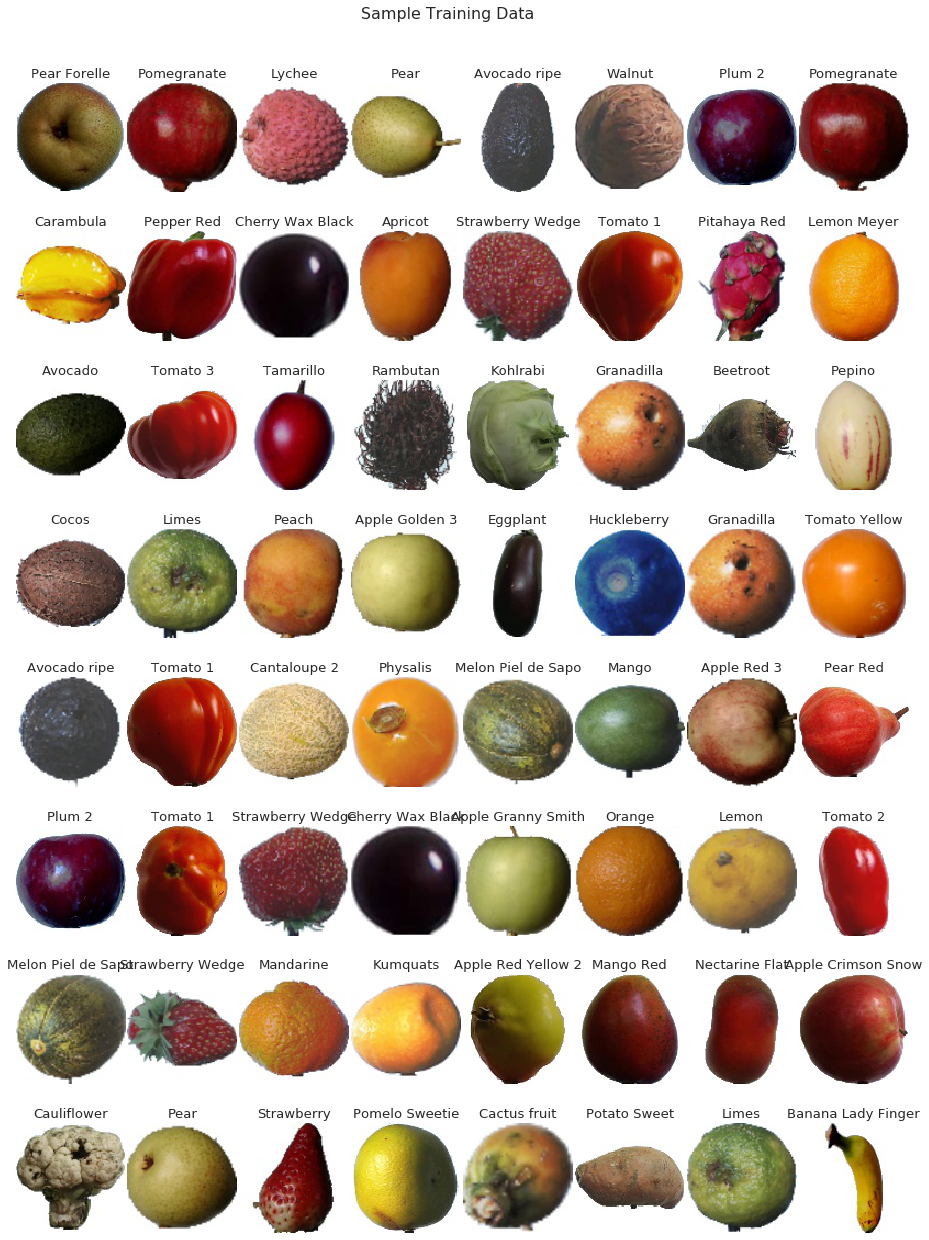

In [0]:
images, labels = train_generator.next()
labels = np.argmax(labels, axis=1)
display_sample(images[:64], labels[:64], num_rows=8, num_cols=8, plot_title='Sample Training Data', fig_size=(16,20))

## Using VGG19 Pre-trained Model

VGG19 is a popular pre-trained model for image classification. It is a layered model and simple to understand. In this section, we will download weights of the VGG19 model and "chop off" the upper Dense layers. In an image classifier, the Conv2D layers are the ones that learn the edges, boundaries and patterns in the image, which is what I want to keep. The Dense layers generate the predictions from the detected patterns - so I'll want to replace these with my own layers (hence the dropping-off of the Dense layers).

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

K.clear_session()  # tf.reset_default_graph()

# NOTE: will download the weights for imagenet
vgg16_base = VGG16(
    weights='imagenet',    # use weights for ImageNet
    include_top=False,     # don't use upper Dense layers
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
print(vgg16_base.summary())

58892288/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
______________________________________________________________

In [0]:
def build_model_vgg16(use_l2_loss=True):
    from tensorflow.keras.optimizers import Adam, SGD
    from tensorflow.keras.regularizers import l2
    
    l2_loss_lambda = 0.00002  # just a wee-bit :)
    l2_loss = l2(l2_loss_lambda) if use_l2_loss else None
    if l2_loss is not None: print('Using l2_loss_lambda = %f' % l2_loss_lambda)
        
    model = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg16_base,
        # here is our custom prediction layer (same as before) 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(2048, activation='relu', kernel_regularizer=l2_loss),
        tf.keras.layers.Dropout(0.10),      
        tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2_loss),
        tf.keras.layers.Dropout(0.10),        
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2_loss),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')    
    ])
    
    # mark vgg16-base layer as non-trainable, so training updates
    # weights and biases of just our newly added layers
    vgg16_base.trainable = False
    
    adam = Adam(lr=LR_START)
    sgd = SGD(lr=1e-1, momentum=0.9, decay=1e-1 / NUM_EPOCHS)
    
    model.compile(optimizer=sgd, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
try:
    del model
except NameError:
    pass # model is not defined!

model = build_model_vgg16()
print(model.summary())

Using l2_loss_lambda = 0.000020
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              9439232   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)     

### Training the model with `ImageDataGenerator's`

In [0]:
# train the model
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_step(epoch, curr_lr):
    power = (epoch % 5) # [0-19] = 0, [20-39] = 1, [40-59] = 2...
    new_lr = LR_START * 1.0 / (1 + 0.01 * power)
    return new_lr

lr_callback = LearningRateScheduler(lr_step, verbose=1)

# train model on generator
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=NUM_EPOCHS,
    validation_data=eval_generator,
    validation_steps=eval_steps,
    workers=3,
    #callbacks=[lr_callback]
)

Epoch 1/30
472/472 [==============================] - 592s 1s/step - loss: 2.3137 - accuracy: 0.4030 - val_loss: 0.8027 - val_accuracy: 0.7869
Epoch 2/30
472/472 [==============================] - 588s 1s/step - loss: 0.7735 - accuracy: 0.7855 - val_loss: 0.2986 - val_accuracy: 0.9440
Epoch 3/30
472/472 [==============================] - 587s 1s/step - loss: 0.4515 - accuracy: 0.8874 - val_loss: 0.1844 - val_accuracy: 0.9817
Epoch 4/30
472/472 [==============================] - 587s 1s/step - loss: 0.3465 - accuracy: 0.9208 - val_loss: 0.1561 - val_accuracy: 0.9909
Epoch 5/30
472/472 [==============================] - 586s 1s/step - loss: 0.2856 - accuracy: 0.9414 - val_loss: 0.1430 - val_accuracy: 0.9922
Epoch 6/30
472/472 [==============================] - 586s 1s/step - loss: 0.2511 - accuracy: 0.9537 - val_loss: 0.1336 - val_accuracy: 0.9956
Epoch 7/30
472/472 [==============================] - 586s 1s/step - loss: 0.2273 - accuracy: 0.9617 - val_loss: 0.1271 - val_accuracy: 0.9977

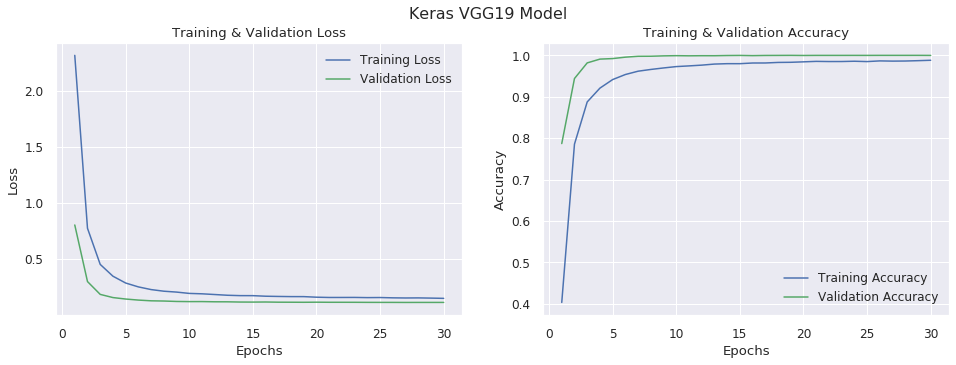

In [0]:
kru.show_plots(hist.history, "Keras VGG19 Model")

In [0]:
# evaluate performance on train & test data
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1, workers=3)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(eval_generator, steps=eval_steps, verbose=1, workers=3)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1, workers=3)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

472/472 [==============================] - 177s 374ms/step - loss: 0.1124 - accuracy: 0.9999
Training data  -> loss: 0.112, acc: 1.000
331/331 [==============================] - 124s 374ms/step - loss: 0.1128 - accuracy: 0.9998
Cross-val data -> loss: 0.113, acc: 1.000
47/47 [==============================] - 18s 375ms/step - loss: 0.1454 - accuracy: 0.9934
Testing data   -> loss: 0.145, acc: 0.993


Wow! Is this the perfect model or what?? [pinch me please!!]
* We are getting 100% accuracy on both the `training` and `cross-validation` datasets
* Accuracy on the `test` set is a shade above `99%`

In [0]:
kru.save_keras_model(model, "kr_fruits360_vgg16", MODEL_SAVE_DIR)
del model

Saved model to file /content/drive/My Drive/Colab Notebooks/keras/model_states/kr_fruits360_vgg16.h5


In [0]:
model = kru.load_keras_model("kr_fruits360_vgg16", MODEL_SAVE_DIR)
print(model.summary())

Loaded Keras model from /content/drive/My Drive/Colab Notebooks/keras/model_states/kr_fruits360_vgg16.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              9439232   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________

In [0]:
print('Running predictions...')

test_generator = test_datagen.flow_from_directory(
    test_folder_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    subset='validation')

all_predictions, all_labels = [], []
for i in range(test_steps):
    # grab the next set of images & labels
    images, labels = test_generator.next()
    # labels will be one-hot-encoded, so decode them to number between (0,NUM_CLASSES]
    labels = np.argmax(labels, axis=1)
    # get one-hot-encoded predictions, which we also decode
    y_pred = np.argmax(model.predict(images), axis=1)
    all_predictions.extend(y_pred.astype('int32'))
    all_labels.extend(labels.astype('int32'))

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

print('First 25 results:')
print('  - Actuals    : ', all_labels[:25])
print('  - Predictions: ', all_predictions[:25])
correct_pred_count = (all_labels == all_predictions).sum()
test_acc = correct_pred_count / len(all_labels)
print('We got %d of %d correct (or %.3f accuracy)' % (correct_pred_count, len(all_labels), test_acc))

Running predictions...
Found 6127 images belonging to 120 classes.
First 25 results:
  - Actuals    :  [116  53   8  87  39  12  46  38   0  58  37  23  44  27  15  46  42  73  16  47  10  28  67  31  52]
  - Predictions:  [116  53   8  87  39  12  46  38   0  58  37  23  44  27  15  46  42  73  36  47  10  28  67  31  52]
We got 5979 of 6016 correct (or 0.994 accuracy)


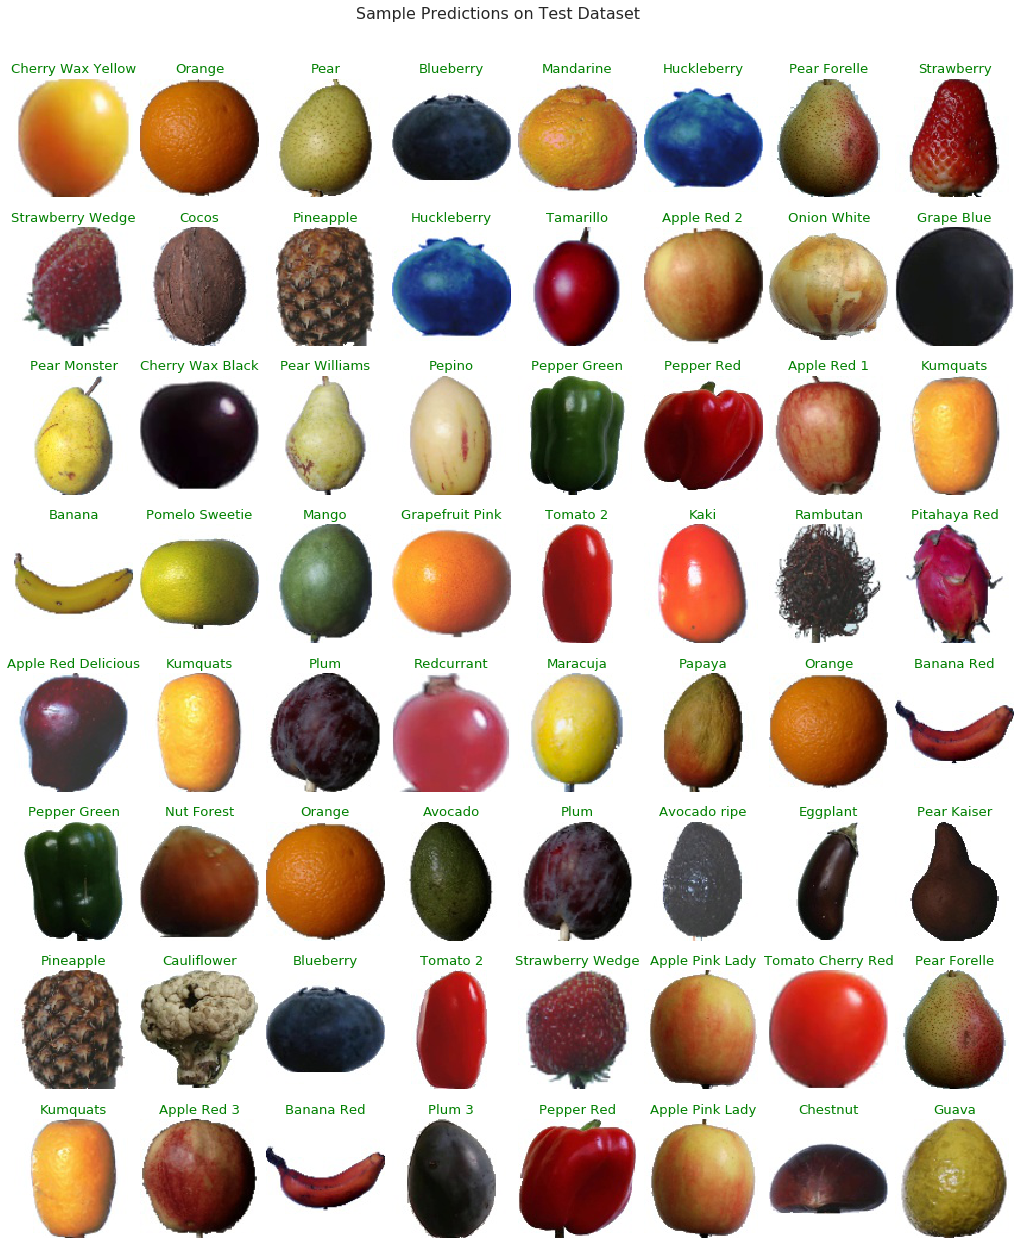

In [0]:
# display sample predictions
images, labels = test_generator.next()
labels = np.argmax(labels, axis=1)
predictions = np.argmax(model.predict(images), axis=1)
display_sample(images[:64], labels[:64], sample_predictions=predictions[:64], num_rows=8, num_cols=8, 
               plot_title='Sample Predictions on Test Dataset', fig_size=(18,20))

In [0]:
# let's see the confusion matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.72      1.00      0.83        48
           1       1.00      1.00      1.00        42
           2       1.00      0.98      0.99        48
           3       1.00      1.00      1.00        49
           4       1.00      1.00      1.00        47
           5       1.00      1.00      1.00        48
           6       1.00      1.00      1.00        44
           7       1.00      1.00      1.00        48
           8       1.00      1.00      1.00        48
           9       1.00      1.00      1.00        43
          10       1.00      1.00      1.00        49
          11       1.00      1.00      1.00        49
          12       1.00      1.00      1.00        64
          13       1.00      1.00      1.00        49
          14       1.00      1.00      1.00        42
          15       1.00      1.00      1.00        49
          16       1.00      0.98      0.99        47
          17       1.00    

**Observations:**

>Configuration | Training Acc | Cross-Val Acc | Testing Acc 
>:---|:---:|:---:|:---:|
>**VGG16 Base Model**|100%|100%|99.4%|

* From the loss & accuracy plots, we see that the model trails the validation metrics for almost all epochs before 'catching up'.
* We appear to have achieved the impossible :)! A near perfect model - with 100% training accuracy & almost 100% test accuracy.

In [0]:
#!rm -r /tmp/cell_images
del vgg16_base
del model

# <center>---- END ----</center>